## 

## sklearn GLM Example

In [1]:
from functools import partial

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.datasets import fetch_openml
from sklearn.metrics import mean_tweedie_deviance
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

def plot_obs_pred(
    df,
    feature,
    weight,
    observed,
    predicted,
    y_label=None,
    title=None,
    ax=None,
    fill_legend=False,
):
    """Plot observed and predicted - aggregated per feature level.

    Parameters
    ----------
    df : DataFrame
        input data
    feature: str
        a column name of df for the feature to be plotted
    weight : str
        column name of df with the values of weights or exposure
    observed : str
        a column name of df with the observed target
    predicted : DataFrame
        a dataframe, with the same index as df, with the predicted target
    fill_legend : bool, default=False
        whether to show fill_between legend
    """
    # aggregate observed and predicted variables by feature level
    df_ = df.loc[:, [feature, weight]].copy()
    df_["observed"] = df[observed] * df[weight]
    df_["predicted"] = predicted * df[weight]
    df_ = (
        df_.groupby([feature])[[weight, "observed", "predicted"]]
        .sum()
        .assign(observed=lambda x: x["observed"] / x[weight])
        .assign(predicted=lambda x: x["predicted"] / x[weight])
    )

    ax = df_.loc[:, ["observed", "predicted"]].plot(style=".", ax=ax)
    y_max = df_.loc[:, ["observed", "predicted"]].values.max() * 0.8
    p2 = ax.fill_between(
        df_.index,
        0,
        y_max * df_[weight] / df_[weight].values.max(),
        color="g",
        alpha=0.1,
    )
    if fill_legend:
        ax.legend([p2], ["{} distribution".format(feature)])
    ax.set(
        ylabel=y_label if y_label is not None else None,
        title=title if title is not None else "Train: Observed vs Predicted",
    )


def score_estimator(
    estimator,
    X_train,
    X_test,
    df_train,
    df_test,
    target,
    weights,
    tweedie_powers=None,
):
    """Evaluate an estimator on train and test sets with different metrics"""

    metrics = [
        ("D² explained", None),  # Use default scorer if it exists
        ("mean abs. error", mean_absolute_error),
        ("mean squared error", mean_squared_error),
    ]
    if tweedie_powers:
        metrics += [
            (
                "mean Tweedie dev p={:.4f}".format(power),
                partial(mean_tweedie_deviance, power=power),
            )
            for power in tweedie_powers
        ]

    res = []
    for subset_label, X, df in [
        ("train", X_train, df_train),
        ("test", X_test, df_test),
    ]:
        y, _weights = df[target], df[weights]
        for score_label, metric in metrics:
            if isinstance(estimator, tuple) and len(estimator) == 2:
                # Score the model consisting of the product of frequency and
                # severity models.
                est_freq, est_sev = estimator
                y_pred = est_freq.predict(X) * est_sev.predict(X)
            else:
                y_pred = estimator.predict(X)

            if metric is None:
                if not hasattr(estimator, "score"):
                    continue
                score = estimator.score(X, y, sample_weight=_weights)
            else:
                score = metric(y, y_pred, sample_weight=_weights)

            res.append({"subset": subset_label, "metric": score_label, "score": score})

    res = (
        pd.DataFrame(res)
        .set_index(["metric", "subset"])
        .score.unstack(-1)
        .round(4)
        .loc[:, ["train", "test"]]
    )
    return res

In [2]:
df=pd.read_csv('datacar.csv')
df.drop('Unnamed: 0',axis=1,inplace=True)


In [3]:
#Need to do basic data prep in order to apply current framework to new data
df=df.rename(columns={'numclaims':'ClaimNb','claimcst0':'ClaimAmount','exposure':'Exposure','veh_age':'VehAge'})

df.drop(['clm','X_OBSTAT_'],axis=1,inplace=True)

In [4]:
#Load Data
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder
from sklearn.preprocessing import StandardScaler, KBinsDiscretizer
from sklearn.compose import ColumnTransformer

# Note: filter out claims with zero amount, as the severity model
# requires strictly positive target values.
df.loc[(df["ClaimAmount"] == 0) & (df["ClaimNb"] >= 1), "ClaimNb"] = 0

# Correct for unreasonable observations (that might be data error)
# and a few exceptionally large claim amounts
df["ClaimNb"] = df["ClaimNb"].clip(upper=4)
df["Exposure"] = df["Exposure"].clip(upper=1)
df["ClaimAmount"] = df["ClaimAmount"].clip(upper=10000)

log_scale_transformer = make_pipeline(
    FunctionTransformer(func=np.log), StandardScaler()
)

column_trans = ColumnTransformer(
    [
        (
            "binned_numeric",
            KBinsDiscretizer(n_bins=10, subsample=int(2e5), random_state=0),
            ["veh_value"],
        ),
        (
            "onehot_categorical",
            OneHotEncoder(),
            ["veh_body", "area", "gender"],
        ),
        ("passthrough_numeric", "passthrough", ["VehAge","agecat"]),
       # ("log_scaled_numeric", log_scale_transformer, ["Density"]),
    ],
    remainder="drop",
)
X = column_trans.fit_transform(df)

# Insurances companies are interested in modeling the Pure Premium, that is
# the expected total claim amount per unit of exposure for each policyholder
# in their portfolio:
df["PurePremium"] = df["ClaimAmount"] / df["Exposure"]

# This can be indirectly approximated by a 2-step modeling: the product of the
# Frequency times the average claim amount per claim:
df["Frequency"] = df["ClaimNb"] / df["Exposure"]
df["AvgClaimAmount"] = df["ClaimAmount"] / np.fmax(df["ClaimNb"], 1)

with pd.option_context("display.max_columns", 15):
    print(df[df.ClaimAmount > 0].head())

    veh_value  Exposure  ClaimNb  ClaimAmount veh_body  VehAge gender area   
14       1.66  0.484600        1   669.509999    SEDAN       3      M    B  \
16       1.51  0.993840        1   806.609999    SEDAN       3      F    F   
17       0.76  0.539357        1   401.805451    HBACK       3      M    C   
40       1.89  0.654346        2  1811.709997    STNWG       3      M    F   
64       4.06  0.851472        1  5434.439987    STNWG       2      M    F   

    agecat  PurePremium  Frequency  AvgClaimAmount  
14       6  1381.573600   2.063559      669.509999  
16       4   811.609647   1.006198      806.609999  
17       4   744.971782   1.854061      401.805451  
40       2  2768.732538   3.056485      905.854999  
64       3  6382.409020   1.174437     5434.439987  


In [5]:
#Freq Model
from sklearn.model_selection import train_test_split
from sklearn.linear_model import PoissonRegressor


df_train, df_test, X_train, X_test = train_test_split(df, X, random_state=0)

glm_freq = PoissonRegressor(alpha=1e-4, solver="newton-cholesky")
glm_freq.fit(X_train, df_train["Frequency"], sample_weight=df_train["Exposure"])

scores = score_estimator(
    glm_freq,
    X_train,
    X_test,
    df_train,
    df_test,
    target="Frequency",
    weights="Exposure",
)
print("Evaluation of PoissonRegressor on target Frequency")
print(scores)

Evaluation of PoissonRegressor on target Frequency
subset               train    test
metric                            
D² explained        0.0032  0.0024
mean abs. error     0.2823  0.2814
mean squared error  0.4826  0.4190


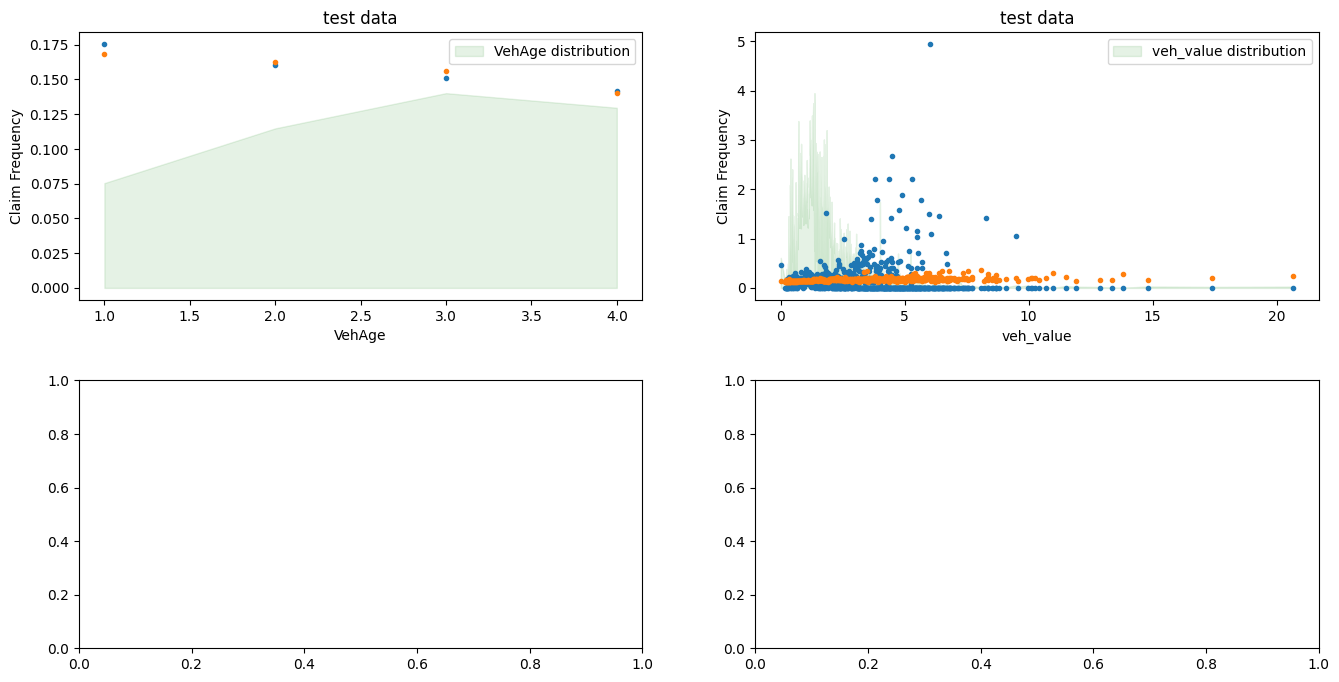

In [12]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(16, 8))
fig.subplots_adjust(hspace=0.3, wspace=0.2)

#plot_obs_pred(
#    df=df_train,
#    feature="DrivAge",
#    weight="Exposure",
#    observed="Frequency",
#    predicted=glm_freq.predict(X_train),
#    y_label="Claim Frequency",
#    title="train data",
#    ax=ax[0, 0],
#)

#plot_obs_pred(
#    df=df_test,
#    feature="DrivAge",
#    weight="Exposure",
#    observed="Frequency",
#    predicted=glm_freq.predict(X_test),
#    y_label="Claim Frequency",
#    title="test data",
#    ax=ax[0, 1],
#    fill_legend=True,
#)

plot_obs_pred(
    df=df_test,
    feature="VehAge",
    weight="Exposure",
    observed="Frequency",
    predicted=glm_freq.predict(X_test),
    y_label="Claim Frequency",
    title="test data",
    ax=ax[0, 0],
    fill_legend=True,
)

plot_obs_pred(
    df=df_test,
    feature="veh_value",
    weight="Exposure",
    observed="Frequency",
    predicted=glm_freq.predict(X_test),
    y_label="Claim Frequency",
    title="test data",
    ax=ax[0, 1],
    fill_legend=True,
)

In [13]:
from sklearn.linear_model import GammaRegressor


mask_train = df_train["ClaimAmount"] > 0
mask_test = df_test["ClaimAmount"] > 0

glm_sev = GammaRegressor(alpha=10.0, solver="newton-cholesky")

glm_sev.fit(
    X_train[mask_train.values],
    df_train.loc[mask_train, "AvgClaimAmount"],
    sample_weight=df_train.loc[mask_train, "ClaimNb"],
)

scores = score_estimator(
    glm_sev,
    X_train[mask_train.values],
    X_test[mask_test.values],
    df_train[mask_train],
    df_test[mask_test],
    target="AvgClaimAmount",
    weights="ClaimNb",
)
print("Evaluation of GammaRegressor on target AvgClaimAmount")
print(scores)

Evaluation of GammaRegressor on target AvgClaimAmount
subset                     train          test
metric                                        
D² explained        1.600000e-03  1.600000e-03
mean abs. error     1.561511e+03  1.546287e+03
mean squared error  5.117401e+06  4.950856e+06


In [14]:
from sklearn.dummy import DummyRegressor

dummy_sev = DummyRegressor(strategy="mean")
dummy_sev.fit(
    X_train[mask_train.values],
    df_train.loc[mask_train, "AvgClaimAmount"],
    sample_weight=df_train.loc[mask_train, "ClaimNb"],
)

scores = score_estimator(
    dummy_sev,
    X_train[mask_train.values],
    X_test[mask_test.values],
    df_train[mask_train],
    df_test[mask_test],
    target="AvgClaimAmount",
    weights="ClaimNb",
)
print("Evaluation of a mean predictor on target AvgClaimAmount")
print(scores)

Evaluation of a mean predictor on target AvgClaimAmount
subset                     train          test
metric                                        
D² explained        0.000000e+00 -2.000000e-04
mean abs. error     1.565361e+03  1.549212e+03
mean squared error  5.128085e+06  4.962796e+06


In [15]:
print(
    "Mean AvgClaim Amount per policy:              %.2f "
    % df_train["AvgClaimAmount"].mean()
)
print(
    "Mean AvgClaim Amount | NbClaim > 0:           %.2f"
    % df_train["AvgClaimAmount"][df_train["AvgClaimAmount"] > 0].mean()
)
print(
    "Predicted Mean AvgClaim Amount | NbClaim > 0: %.2f"
    % glm_sev.predict(X_train).mean()
)
print(
    "Predicted Mean AvgClaim Amount (dummy) | NbClaim > 0: %.2f"
    % dummy_sev.predict(X_train).mean()
)

Mean AvgClaim Amount per policy:              117.28 
Mean AvgClaim Amount | NbClaim > 0:           1713.17
Predicted Mean AvgClaim Amount | NbClaim > 0: 1682.89
Predicted Mean AvgClaim Amount (dummy) | NbClaim > 0: 1687.19


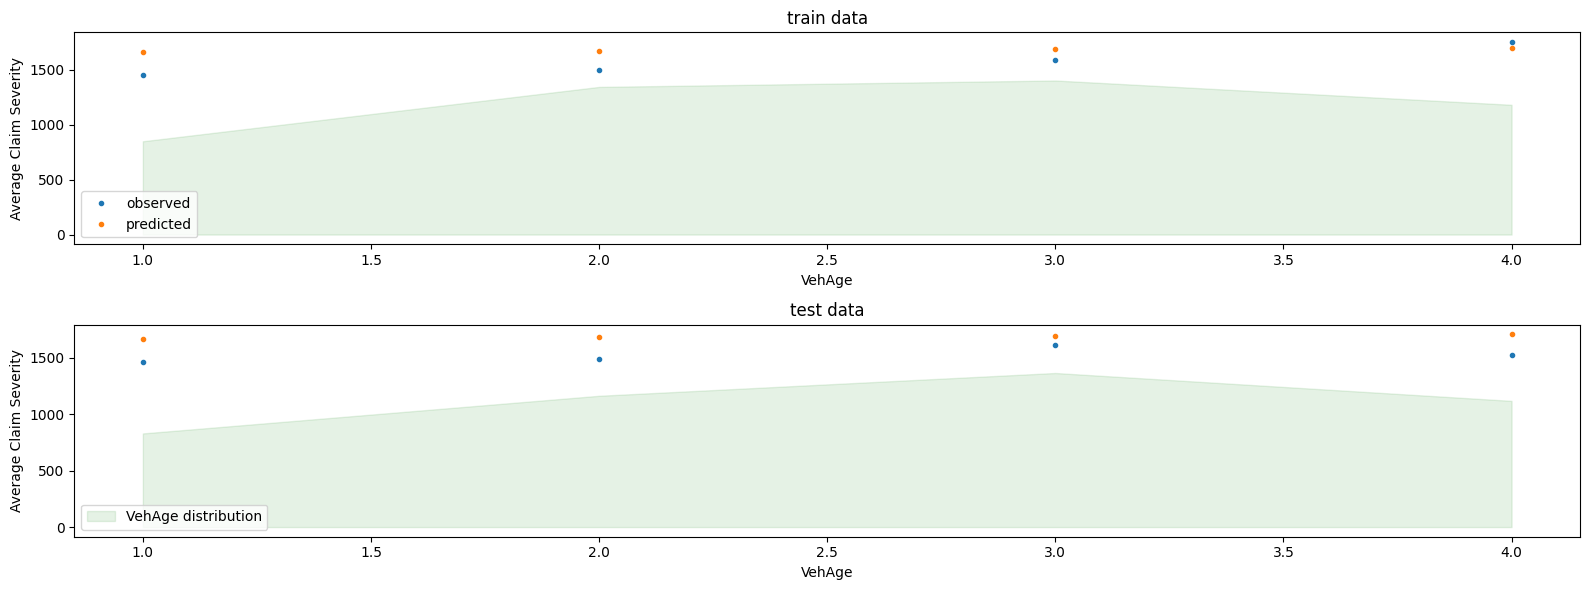

In [16]:
fig, ax = plt.subplots(ncols=1, nrows=2, figsize=(16, 6))

plot_obs_pred(
    df=df_train.loc[mask_train],
    feature="VehAge",
    weight="Exposure",
    observed="AvgClaimAmount",
    predicted=glm_sev.predict(X_train[mask_train.values]),
    y_label="Average Claim Severity",
    title="train data",
    ax=ax[0],
)

plot_obs_pred(
    df=df_test.loc[mask_test],
    feature="VehAge",
    weight="Exposure",
    observed="AvgClaimAmount",
    predicted=glm_sev.predict(X_test[mask_test.values]),
    y_label="Average Claim Severity",
    title="test data",
    ax=ax[1],
    fill_legend=True,
)
plt.tight_layout()

In [17]:
from sklearn.linear_model import TweedieRegressor


glm_pure_premium = TweedieRegressor(power=1.9, alpha=0.1, solver="newton-cholesky")
glm_pure_premium.fit(
    X_train, df_train["PurePremium"], sample_weight=df_train["Exposure"]
)

tweedie_powers = [1.5, 1.7, 1.8, 1.9, 1.99, 1.999, 1.9999]

scores_product_model = score_estimator(
    (glm_freq, glm_sev),
    X_train,
    X_test,
    df_train,
    df_test,
    target="PurePremium",
    weights="Exposure",
    tweedie_powers=tweedie_powers,
)

scores_glm_pure_premium = score_estimator(
    glm_pure_premium,
    X_train,
    X_test,
    df_train,
    df_test,
    target="PurePremium",
    weights="Exposure",
    tweedie_powers=tweedie_powers,
)

scores = pd.concat(
    [scores_product_model, scores_glm_pure_premium],
    axis=1,
    sort=True,
    keys=("Product Model", "TweedieRegressor"),
)
print("Evaluation of the Product Model and the Tweedie Regressor on target PurePremium")
with pd.option_context("display.expand_frame_repr", False):
    print(scores)

Evaluation of the Product Model and the Tweedie Regressor on target PurePremium
                          Product Model               TweedieRegressor              
subset                            train          test            train          test
metric                                                                              
D² explained                        NaN           NaN     3.300000e-03  3.500000e-03
mean Tweedie dev p=1.5000  9.794490e+01  9.692940e+01     9.757670e+01  9.636520e+01
mean Tweedie dev p=1.7000  4.267880e+01  4.240300e+01     4.255470e+01  4.221730e+01
mean Tweedie dev p=1.8000  3.317820e+01  3.302680e+01     3.310610e+01  3.292040e+01
mean Tweedie dev p=1.9000  3.465650e+01  3.456410e+01     3.461460e+01  3.450300e+01
mean Tweedie dev p=1.9900  1.942993e+02  1.941132e+02     1.942736e+02  1.940762e+02
mean Tweedie dev p=1.9990  1.834276e+03  1.832834e+03     1.834251e+03  1.832798e+03
mean Tweedie dev p=1.9999  1.823749e+04  1.822347e+04     1.823747e+04

In [18]:
res = []
for subset_label, X, df in [
    ("train", X_train, df_train),
    ("test", X_test, df_test),
]:
    exposure = df["Exposure"].values
    res.append(
        {
            "subset": subset_label,
            "observed": df["ClaimAmount"].values.sum(),
            "predicted, frequency*severity model": np.sum(
                exposure * glm_freq.predict(X) * glm_sev.predict(X)
            ),
            "predicted, tweedie, power=%.2f"
            % glm_pure_premium.power: np.sum(exposure * glm_pure_premium.predict(X)),
        }
    )

print(pd.DataFrame(res).set_index("subset").T)

subset                                      train          test
observed                             6.267904e+06  2.023869e+06
predicted, frequency*severity model  6.256872e+06  2.069025e+06
predicted, tweedie, power=1.90       6.220664e+06  2.059289e+06


[]

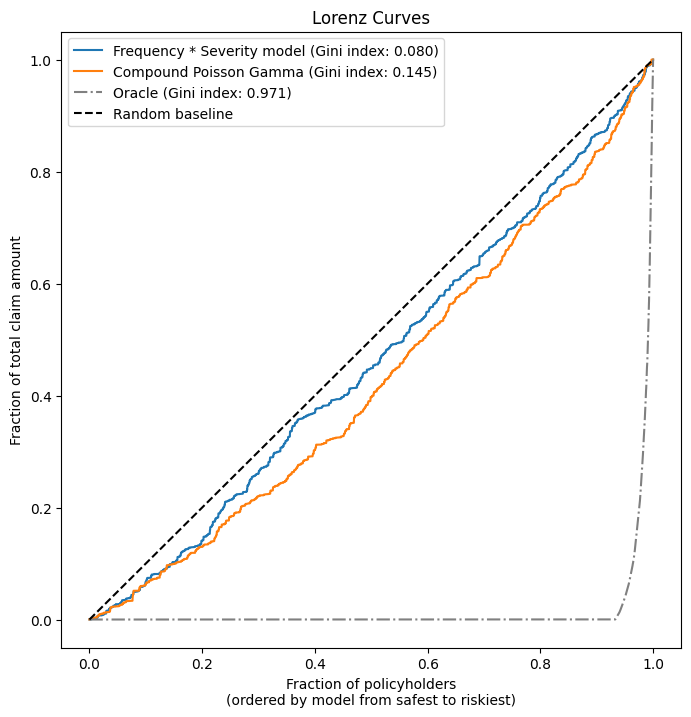

In [19]:
from sklearn.metrics import auc


def lorenz_curve(y_true, y_pred, exposure):
    y_true, y_pred = np.asarray(y_true), np.asarray(y_pred)
    exposure = np.asarray(exposure)

    # order samples by increasing predicted risk:
    ranking = np.argsort(y_pred)
    ranked_exposure = exposure[ranking]
    ranked_pure_premium = y_true[ranking]
    cumulated_claim_amount = np.cumsum(ranked_pure_premium * ranked_exposure)
    cumulated_claim_amount /= cumulated_claim_amount[-1]
    cumulated_samples = np.linspace(0, 1, len(cumulated_claim_amount))
    return cumulated_samples, cumulated_claim_amount


fig, ax = plt.subplots(figsize=(8, 8))

y_pred_product = glm_freq.predict(X_test) * glm_sev.predict(X_test)
y_pred_total = glm_pure_premium.predict(X_test)

for label, y_pred in [
    ("Frequency * Severity model", y_pred_product),
    ("Compound Poisson Gamma", y_pred_total),
]:
    ordered_samples, cum_claims = lorenz_curve(
        df_test["PurePremium"], y_pred, df_test["Exposure"]
    )
    gini = 1 - 2 * auc(ordered_samples, cum_claims)
    label += " (Gini index: {:.3f})".format(gini)
    ax.plot(ordered_samples, cum_claims, linestyle="-", label=label)

# Oracle model: y_pred == y_test
ordered_samples, cum_claims = lorenz_curve(
    df_test["PurePremium"], df_test["PurePremium"], df_test["Exposure"]
)
gini = 1 - 2 * auc(ordered_samples, cum_claims)
label = "Oracle (Gini index: {:.3f})".format(gini)
ax.plot(ordered_samples, cum_claims, linestyle="-.", color="gray", label=label)

# Random baseline
ax.plot([0, 1], [0, 1], linestyle="--", color="black", label="Random baseline")
ax.set(
    title="Lorenz Curves",
    xlabel="Fraction of policyholders\n(ordered by model from safest to riskiest)",
    ylabel="Fraction of total claim amount",
)
ax.legend(loc="upper left")
plt.plot()